In [1]:
import sys
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
import torch
from ELD.utils import preprocess, load_imgs

import cv2 as cv
import numpy as np

In [3]:



MAX_FEATURES = 6000
GOOD_MATCH_PERCENT = 0.3

def alignImagesSIFT(im1Gray, im2Gray, params, plot=False):
    # Detect SIFT features and compute descriptors.
    
    sift = cv2.SIFT_create(MAX_FEATURES, contrastThreshold=params['contrastThreshold'], edgeThreshold=params['edgeThreshold'], sigma=params['sigma'], nOctaveLayers=params['nOctaveLayers'])
    keypoints1, descriptors1 = sift.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(im2Gray, None)

    # Match features using FLANN matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Keep good matches: Lowe's ratio test
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)

    # Sort matches by score
    good_matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(good_matches) * GOOD_MATCH_PERCENT)
    good_matches = good_matches[:20]

    # Draw top matches
    imMatches = cv2.drawMatches(im1Gray, keypoints1, im2Gray, keypoints2, good_matches, None, flags=2)
    if plot:
        fig, ax1 = plt.subplots(1,1, figsize = (8,8))
        ax1.imshow(imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros((len(good_matches), 2), dtype=np.float32)
    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width = im2Gray.shape
    im1Reg = cv2.warpPerspective(im1Gray, h, (width, height))
    
    rmse = (((1.0*im2Gray-im1Reg)**2)**0.5).mean()

    return im1Reg, rmse


import cv2
MAX_FEATURES = 6000
GOOD_MATCH_PERCENT = 0.1
def alignImagesORB(im1Gray, im2Gray, params, plot=False):
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES, edgeThreshold=params['edgeThreshold'], patchSize=params['patchSize'], nlevels=params['nlevels'], fastThreshold=params['fastThreshold'], scaleFactor=params['scaleFactor'], WTA_K=params['WTA_K'])
    #orb = cv.SIFT_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    matches = list(matches)
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
    # Remove not so good matches
    #numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:20]
    # Draw top matches
    #flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    imMatches = cv2.drawMatches(im1Gray, keypoints1, im2Gray, keypoints2, matches, None, flags=2)
    if plot:
        fig, ax1 = plt.subplots(1,1, figsize = (8,8))
        ax1.imshow(imMatches)
    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
        
    
   
        
    # Find homogra
    # phy
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
    #h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)
    # Use homography
    height, width = im2Gray.shape
    im1Reg = cv2.warpPerspective(im1Gray, h, (width, height))
    
    rmse = (((1.0*im2Gray-im1Reg)**2)**0.5).mean()
    
    return im1Reg, rmse


In [4]:
def feature_detect_ORB(imgs):
    # Define the range of values for each parameter
    edgeThreshold_values = [7, 9, 11, 12]
    patchSize_values = [23, 24, 25, 26]
    nlevels_values = [1, 2, 3]
    fastThreshold_values = [12, 13, 14,]
    scaleFactor_values = [1.23, 1.25, 1.3, 1.4]
    WTA_K_values = [3, 4, 5]
    # Initialize variables to store the best parameters and the lowest RMSE
    best_params = None
    lowest_rmse = float('inf')
    
    
    img1 = cv2.cvtColor(imgs[0], cv2.COLOR_BGR2GRAY)

    for ix2 in range(1, len(imgs)-1):
        img2 = cv2.cvtColor(imgs[ix2], cv2.COLOR_BGR2GRAY)

        # Iterate over all combinations of parameters
        for edgeThreshold in edgeThreshold_values:
            for patchSize in patchSize_values:
                for nlevels in nlevels_values:
                    for fastThreshold in fastThreshold_values:
                        for scaleFactor in scaleFactor_values:
                            for WTA_K in WTA_K_values:
                                params = {
                                    "edgeThreshold": edgeThreshold,
                                    "patchSize": patchSize,
                                    "nlevels": nlevels,
                                    "fastThreshold": fastThreshold,
                                    "scaleFactor": scaleFactor,
                                    "WTA_K": WTA_K
                                }
                                try:
                                    best_img, rmse = alignImagesORB(img1, img2,  params)
                                    
                                    # Update the best parameters if a lower RMSE is found
                                    if rmse < lowest_rmse:
                                        lowest_rmse = rmse
                                        best_params = params
                                except:
                                    continue

        mapped_img, rmse = alignImagesORB(img1, img2,  best_params, plot=True)

In [5]:
def feature_detect_SIFT(imgs):
    # Define the range of values for each parameter
    contrastThreshold_vals = [0.005, 0.01, 0.03]
    edgeThreshold_vals = [10, 11, 12,13]
    sigma_vals = [1, 1.1, 1.2, 1.3, 1.4]
    nOctaveLayers_vals = [3, 4, 5, 6]
    # Initialize variables to store the best parameters and the lowest RMSE
    best_params = None
    lowest_rmse = float('inf')


    img1 = cv2.cvtColor(imgs[0], cv2.COLOR_BGR2GRAY)
    
    for ix2 in range(1, len(imgs)-1):
        img2 = cv2.cvtColor(imgs[ix2], cv2.COLOR_BGR2GRAY)

        # Iterate over all combinations of parameters
        for contrastThreshold in contrastThreshold_vals:
            for edgeThreshold in edgeThreshold_vals:
                for sigma in sigma_vals:
                    for nOctaveLayers in nOctaveLayers_vals:
                        params = {
                                    "contrastThreshold": contrastThreshold,
                                    "edgeThreshold": edgeThreshold,
                                    "sigma": sigma,
                                    "nOctaveLayers": nOctaveLayers
                                }
                        try:
                            best_img, rmse = alignImagesSIFT(img1, img2,  params)
                            
                            # Update the best parameters if a lower RMSE is found
                            if rmse < lowest_rmse:
                                lowest_rmse = rmse
                                best_params = params
                        except:
                            continue
                                
        mapped_img, rmse = alignImagesSIFT(img1, img2,  best_params, plot=True)

# MOB

In [6]:
PATH = "/data/ekvall/marcoAnalysis/"
inpath = f'{PATH}MOB_eggplant/'

#load imgs and move to tensor
mob_he = load_imgs(inpath, False)

## MOB ORB

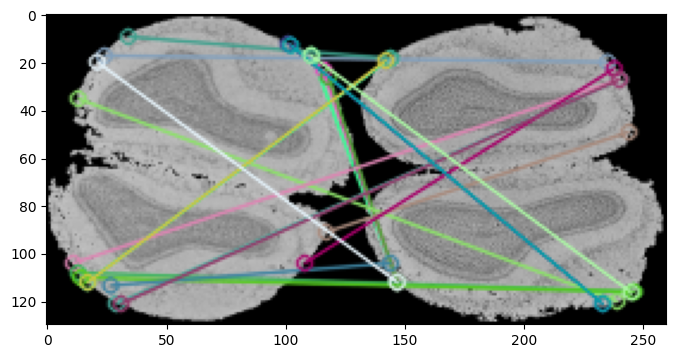

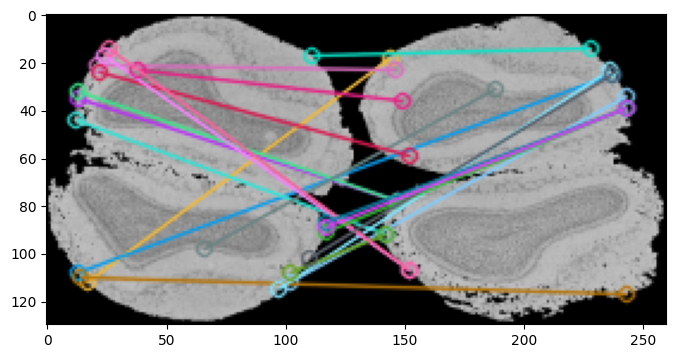

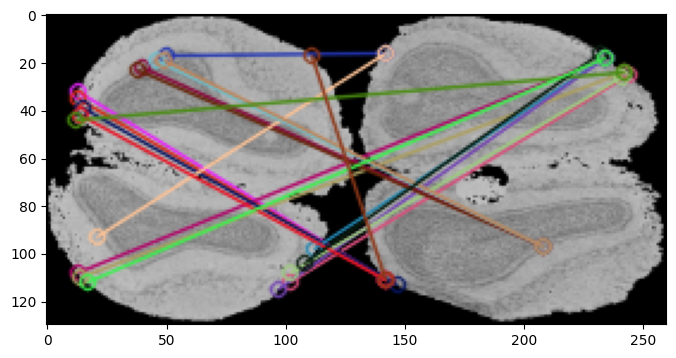

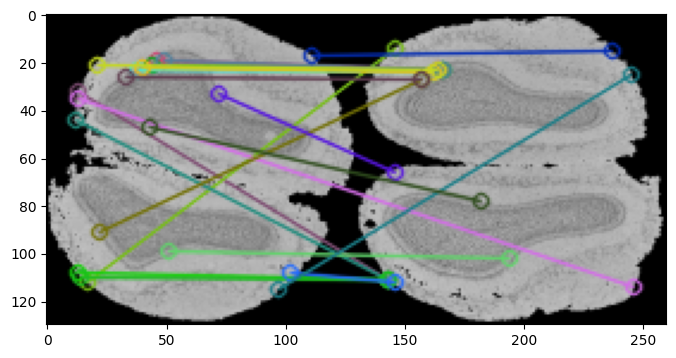

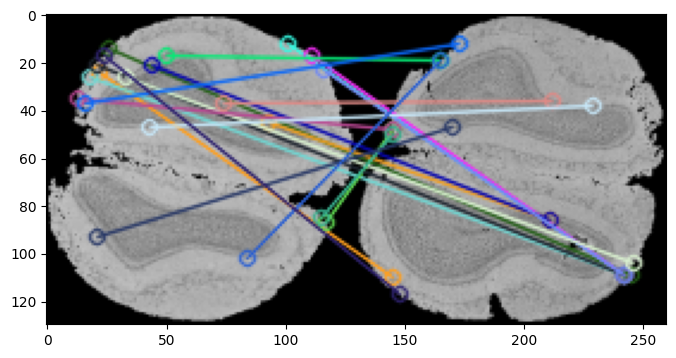

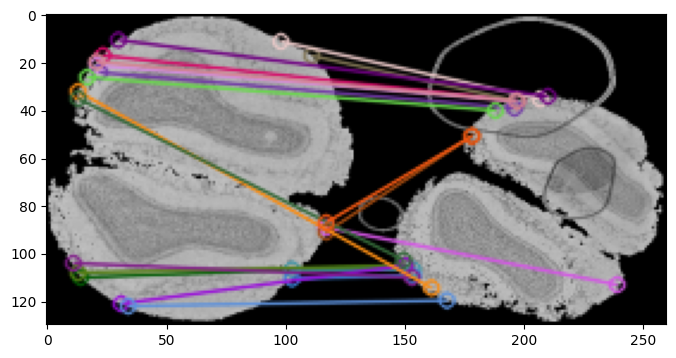

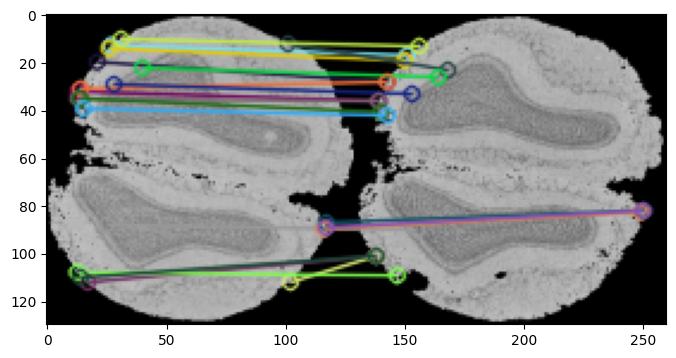

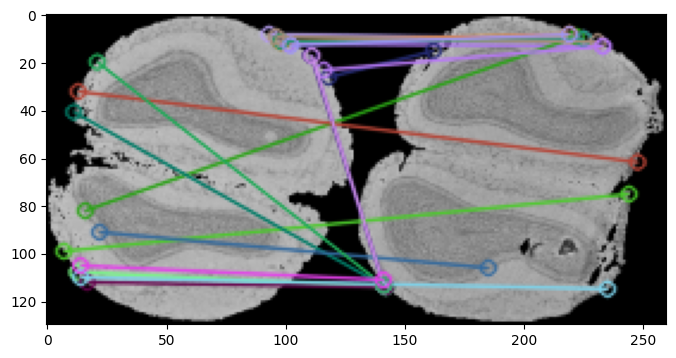

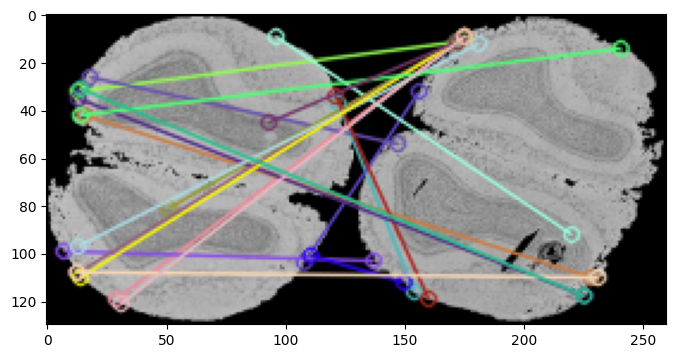

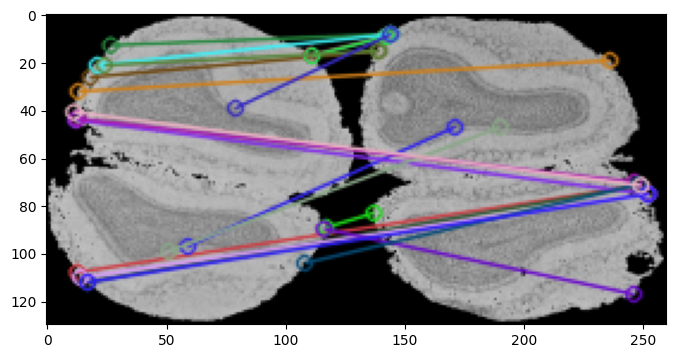

In [7]:
feature_detect_ORB(mob_he)

## MOB SIFT

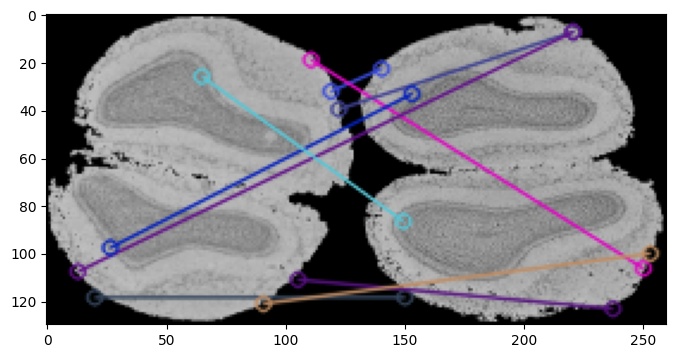

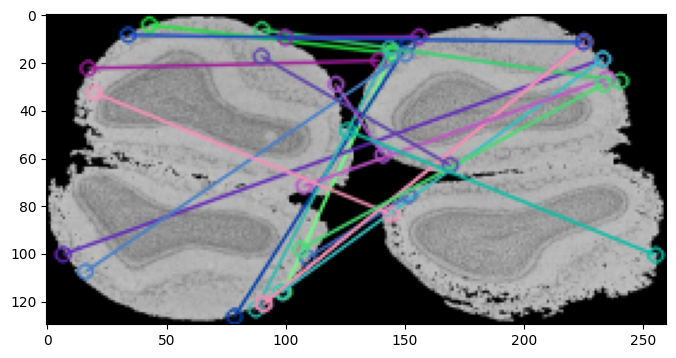

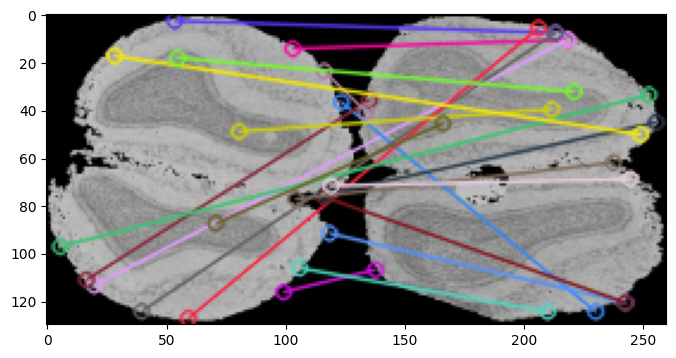

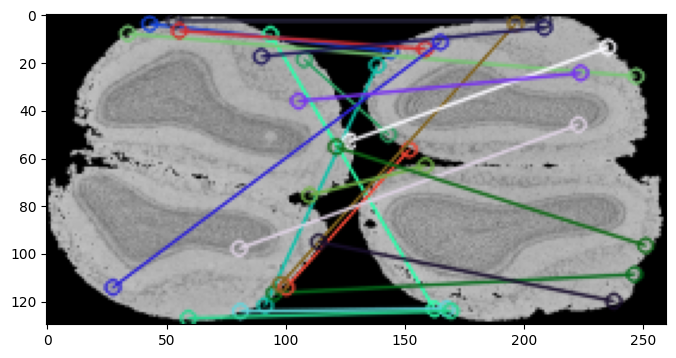

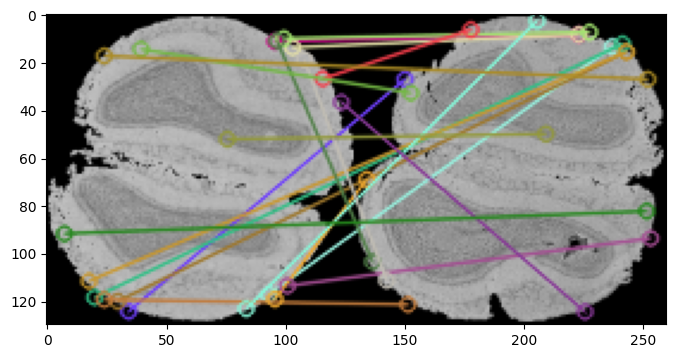

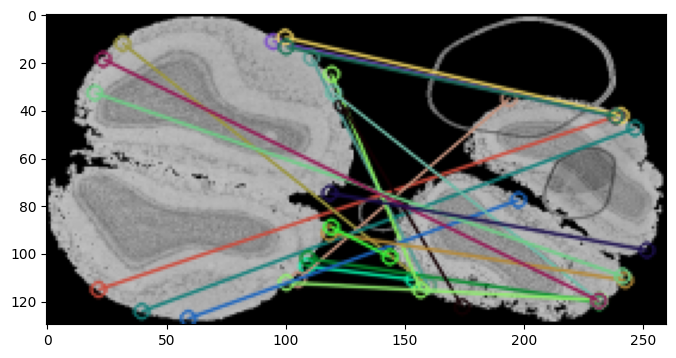

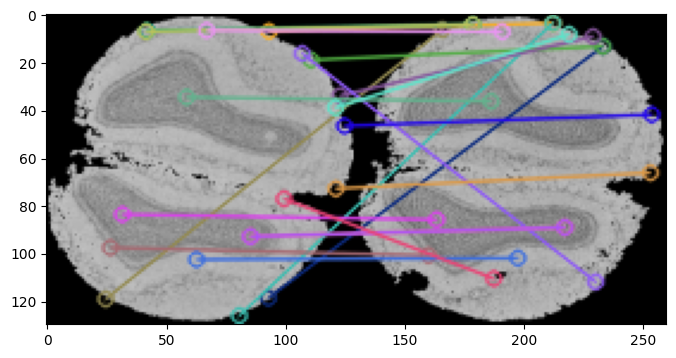

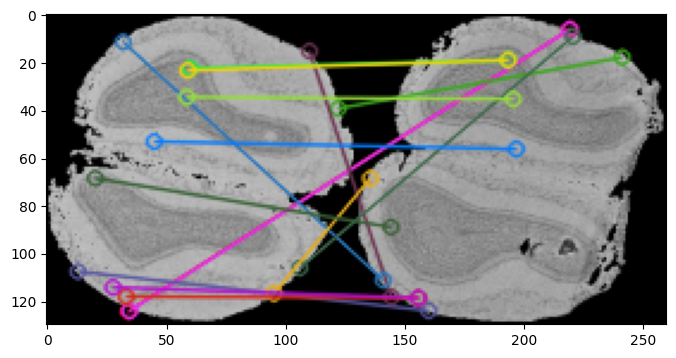

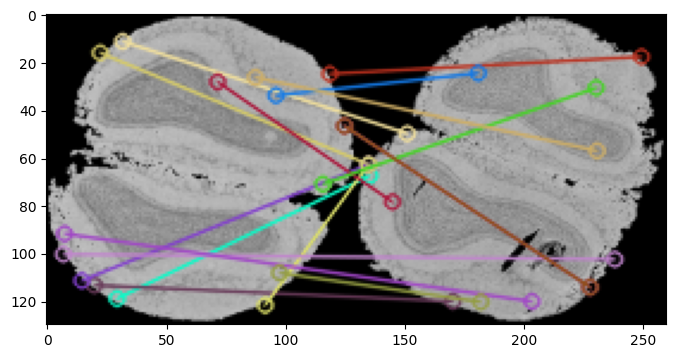

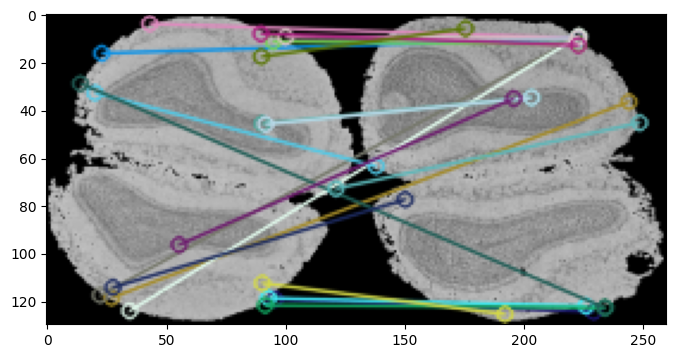

In [8]:
feature_detect_SIFT(mob_he)

# Human squamous cell carcinoma

In [9]:

inpath = f'{PATH}Human_squamous_cell_carcinoma/'
cell_carcinoma = load_imgs(inpath, False)

# Human squamous cell carcinoma ORB

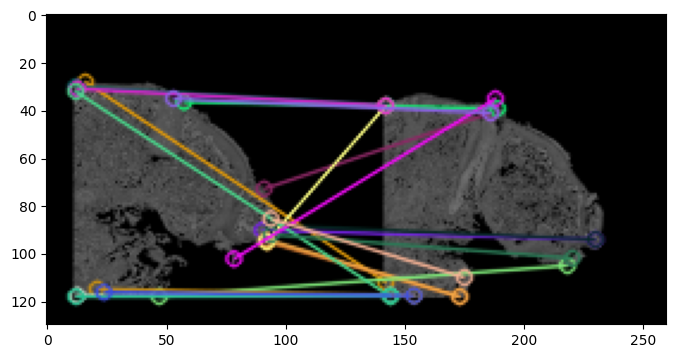

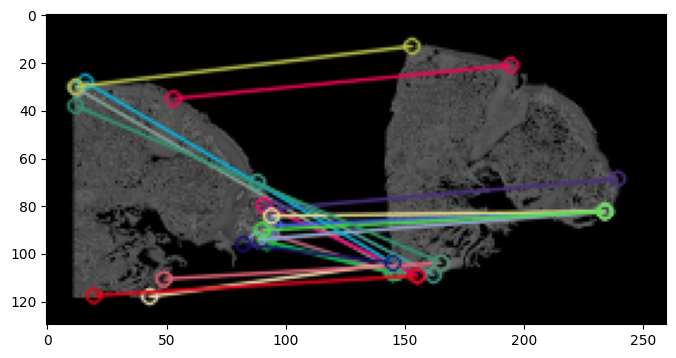

In [10]:
feature_detect_ORB(cell_carcinoma)

# Human squamous cell carcinoma SIFT

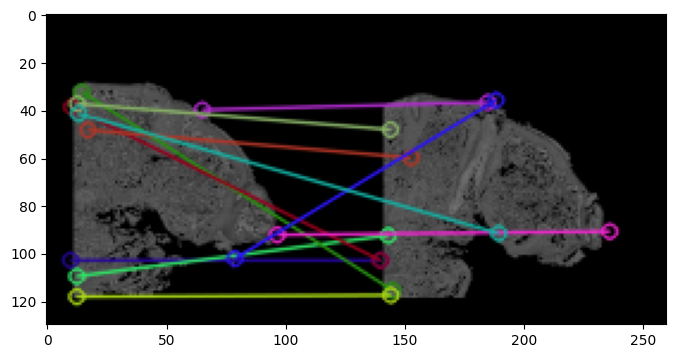

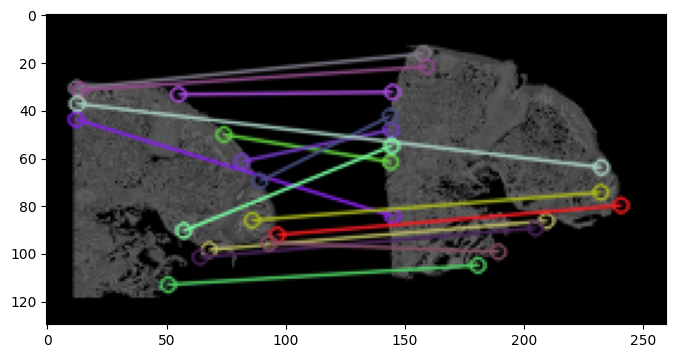

In [11]:
feature_detect_SIFT(cell_carcinoma)

# Human Ileum

In [12]:
inpath = f'{PATH}Human_ileum/'
human_ilum = load_imgs(inpath, False)

## Human Ileum ORB

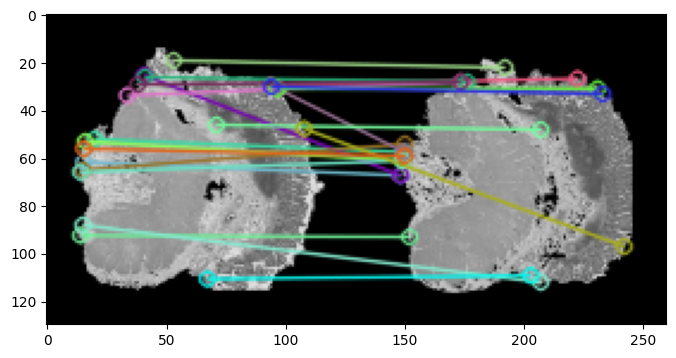

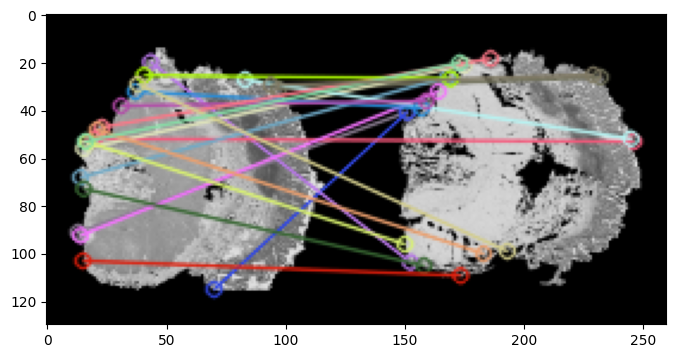

In [13]:
feature_detect_ORB(human_ilum)

## Human Ileum SIFT

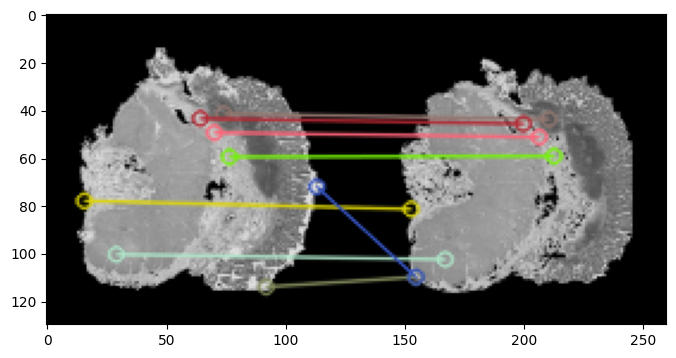

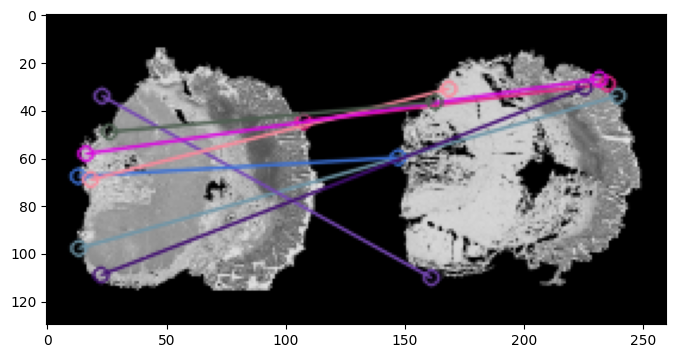

In [14]:
feature_detect_SIFT(human_ilum)